In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import torch
from torch import nn
from torch.optim import Adam, SGD

In [2]:
sarcasm_df = pd.read_csv("data/train-balanced-sarcasm.csv")


In [3]:
sarcasm_df.head()


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [4]:
sarcasm_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


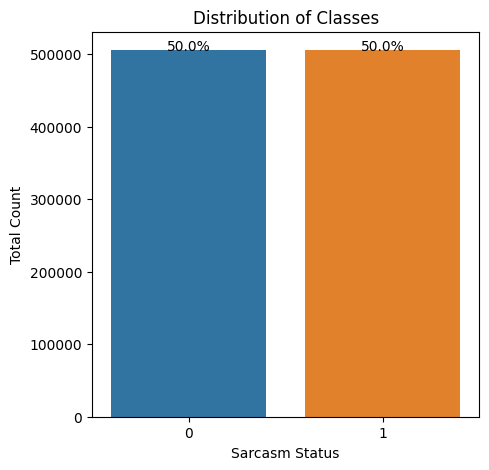

In [5]:
plt.figure(figsize=(5, 5))
ax = sns.countplot(x="label", data=sarcasm_df)
ax.set(title="Distribution of Classes", xlabel="Sarcasm Status", ylabel="Total Count")
total = float(len(sarcasm_df))
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.0,
        height + 3,
        "{:1.1f}%".format((height / total) * 100),
        ha="center",
    )
plt.show()


In [3]:
sarcasm_df["subreddit"].value_counts()[:5]


AskReddit          65677
politics           39496
worldnews          26377
leagueoflegends    21037
pcmasterrace       18988
Name: subreddit, dtype: int64

In [4]:
top_reddits = ["AskReddit", "politics", "worldnews", "leagueoflegends", "pcmasterrace"]

subreddit_df = pd.DataFrame()
subreddit_df["subreddit"] = top_reddits
subreddit_df["sarcastic"] = np.nan
subreddit_df["natural"] = np.nan
subreddit_df["total"] = np.nan

# Calculating the count of Sarcastic and Natural comments for the top 5 subreddits
for i in range(len(top_reddits)):
    temp = sarcasm_df.loc[
        sarcasm_df["subreddit"] == subreddit_df.subreddit.iloc[i]
    ].copy()
    length = len(temp)
    count_sarcastic = len(temp.loc[temp["label"] == 1])
    subreddit_df.loc[i, "sarcastic"] = count_sarcastic
    subreddit_df.loc[i, "natural"] = length - count_sarcastic
    subreddit_df.loc[i, "total"] = length


In [5]:
subreddit_df


,subreddit,sarcastic,natural,total
0,AskReddit,26367.0,39310.0,65677.0
1,politics,23910.0,15586.0,39496.0
2,worldnews,16948.0,9429.0,26377.0
3,leagueoflegends,11409.0,9628.0,21037.0
4,pcmasterrace,10760.0,8228.0,18988.0


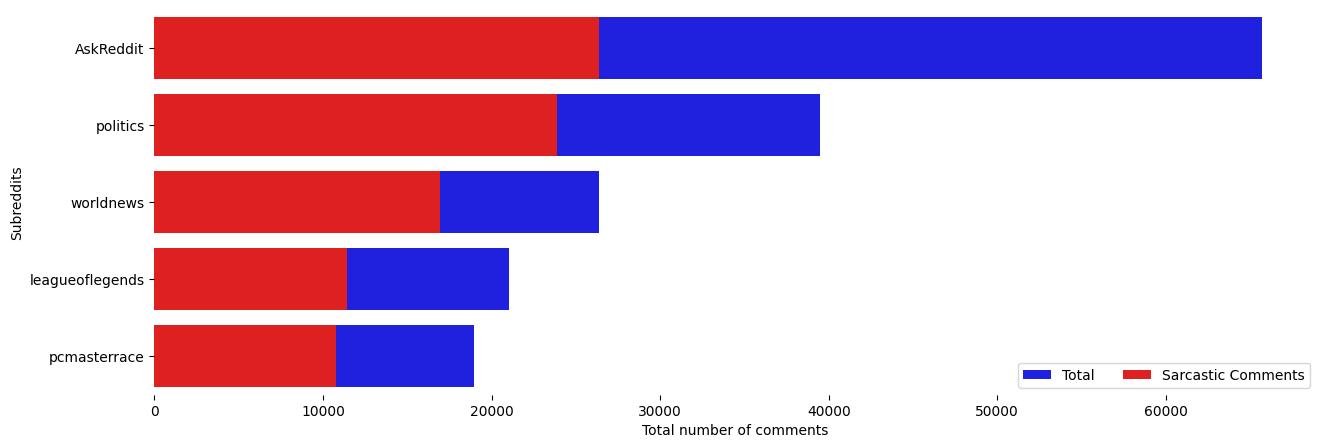

In [6]:
f, ax = plt.subplots(figsize=(15, 5))
# Plot the total comments for the subreddits
sns.barplot(x="total", y="subreddit", data=subreddit_df, label="Total", color="b")
# Plot the total sarcastic comments for the subreddits
sns.barplot(
    x="sarcastic",
    y="subreddit",
    data=subreddit_df,
    label="Sarcastic Comments",
    color="r",
)
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Subreddits", xlabel="Total number of comments")
sns.despine(left=True, bottom=True)


In [10]:
# Preprocessing


In [7]:
# We just need comment & label columns
# So, let's remove others.
sarcasm_df.drop(
    [
        "author",
        "subreddit",
        "score",
        "ups",
        "downs",
        "date",
        "created_utc",
        "parent_comment",
    ],
    axis=1,
    inplace=True,
)
# remove empty rows
sarcasm_df.dropna(inplace=True)
sarcasm_df.head()


,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


In [8]:
# Here we inspect data for missing values
sarcasm_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010773 entries, 0 to 1010825
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   label    1010773 non-null  int64 
 1   comment  1010773 non-null  object
dtypes: int64(1), object(1)
memory usage: 23.1+ MB


In [9]:
# Some comments are missing, so we drop the corresponding rows.
sarcasm_df.dropna(subset=["comment"], inplace=True)
# also convert to lower case and remove punctuation
sarcasm_df["comment"] = sarcasm_df["comment"].str.lower()
sarcasm_df["comment"] = sarcasm_df["comment"].str.replace("[^\w\s]", "")


/tmp/ipykernel_348594/1034982800.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  sarcasm_df["comment"] = sarcasm_df["comment"].str.replace("[^\w\s]", "")


In [10]:
# Now we compare the number of instances for each class (1 - sarcasm, 0 - not sarcasm). We can see, that the dataset is balanced and classes have almost the same size
sarcasm_df["label"].value_counts()


0    505405
1    505368
Name: label, dtype: int64

In [11]:
x_train, x_test, y_train, y_test = train_test_split(
    sarcasm_df["comment"], sarcasm_df["label"], test_size=0.3, random_state=42
)


In [16]:
# create tf-idf encoder
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# encode training data
train_features = tf_idf.fit_transform(x_train)
# encode test data
test_features = tf_idf.transform(x_test)

# logistic regression model with tf-idf encoder
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(train_features, y_train)
pred_labels_log_reg = log_reg.predict(test_features)
print("Logistic regression accuracy: ", accuracy_score(y_test, pred_labels_log_reg))


Logistic regression accuracy:  0.7195513666103841


In [43]:
# load the GloVe embeddings from a text file
def load_glove_embeddings(file):
    embeddings = {}
    with open(file, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings[word] = vector
    return embeddings

# function that returns the mean of the word embeddings for a sentence
def glove_mean(sentence, embeddings, dim=100):
    words = sentence.split()
    vectors = np.zeros((len(words), dim))
    for i, word in enumerate(words):
        if word in embeddings:
            vectors[i] = embeddings[word]
    # check if vectors is empty or contains nan values
    if np.isnan(vectors).any() or len(vectors) == 0:
        # replace with zeros or random numbers
        return np.zeros(dim)
        # return np.random.rand(dim)
    else:
        return np.mean(vectors, axis=0)


# load the GloVe embeddings
glove_file = "glove.6B.100d.txt"
glove_embeddings = load_glove_embeddings(glove_file)

In [44]:
# encode the training and test data using GloVe mean-pooling and convert them to PyTorch tensors
X_train_glove = torch.tensor(
    [glove_mean(sent, glove_embeddings) for sent in x_train], dtype=torch.float32
)
X_test_glove = torch.tensor(
    [glove_mean(sent, glove_embeddings) for sent in x_test], dtype=torch.float32
)

# convert Y_train and Y_test to PyTorch tensors
Y_train_glove = torch.tensor(y_train.values, dtype=torch.long)
Y_test_glove = torch.tensor(y_test.values, dtype=torch.long)

# convert the labels to PyTorch tensors
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [52]:
# the MLP model with one hidden layer of size 50, batch normalization, and ReLU activation
class MLP(nn.Module):
    def __init__(self, input_size=100, hidden_size=100, output_size=2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(0.5)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout2 = nn.Dropout(0.5)
        self.act2 = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.act2(x)
        return x


In [53]:
mlp = MLP()

criterion = nn.CrossEntropyLoss()
optimizer = Adam(mlp.parameters(), lr=0.001, weight_decay=1e-4)

epochs = 100

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = mlp(X_train_glove)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, loss: {loss.item():.4f}")

# forward pass through the model on the test data
outputs = mlp(X_test_glove)
# get the predicted labels by taking the argmax of the outputs
pred_labels_mlp = torch.argmax(outputs, dim=1)
print("Multilayer perceptron accuracy:", accuracy_score(y_test_tensor, pred_labels_mlp))

Epoch 1, loss: 0.7176
Epoch 2, loss: 0.7132
Epoch 3, loss: 0.7086
Epoch 4, loss: 0.7050
Epoch 5, loss: 0.7022
Epoch 6, loss: 0.6999
Epoch 7, loss: 0.6972
Epoch 8, loss: 0.6955
Epoch 9, loss: 0.6942
Epoch 10, loss: 0.6930
Epoch 11, loss: 0.6914
Epoch 12, loss: 0.6902
Epoch 13, loss: 0.6894
Epoch 14, loss: 0.6885
Epoch 15, loss: 0.6874
Epoch 16, loss: 0.6865
Epoch 17, loss: 0.6857
Epoch 18, loss: 0.6849
Epoch 19, loss: 0.6840
Epoch 20, loss: 0.6836
Epoch 21, loss: 0.6830
Epoch 22, loss: 0.6822
Epoch 23, loss: 0.6814
Epoch 24, loss: 0.6811
Epoch 25, loss: 0.6804
Epoch 26, loss: 0.6802
Epoch 27, loss: 0.6796
Epoch 28, loss: 0.6791
Epoch 29, loss: 0.6790
Epoch 30, loss: 0.6785
Epoch 31, loss: 0.6781
Epoch 32, loss: 0.6779
Epoch 33, loss: 0.6773
Epoch 34, loss: 0.6770
Epoch 35, loss: 0.6767
Epoch 36, loss: 0.6760
Epoch 37, loss: 0.6756
Epoch 38, loss: 0.6754
Epoch 39, loss: 0.6751
Epoch 40, loss: 0.6751
Epoch 41, loss: 0.6746
Epoch 42, loss: 0.6742
Epoch 43, loss: 0.6744
Epoch 44, loss: 0.67

In [54]:
# generate the classification report
report = classification_report(y_test_tensor, pred_labels_mlp)
print("Classification report:")
print(report)


Classification report:
              precision    recall  f1-score   support

           0       0.56      0.73      0.64    151387
           1       0.62      0.44      0.51    151845

    accuracy                           0.58    303232
   macro avg       0.59      0.58      0.57    303232
weighted avg       0.59      0.58      0.57    303232



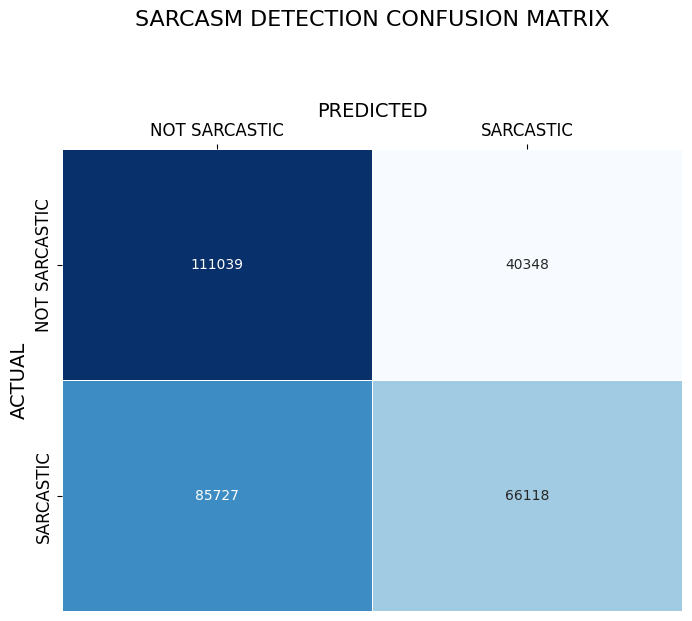

In [55]:
# plot Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test_tensor, pred_labels_mlp), index=['NOT SARCASTIC','SARCASTIC'], columns=['NOT SARCASTIC', 'SARCASTIC'])

fig = plt.figure(figsize=(8,6))
ax = sns.heatmap(cm, annot=True, cbar=False, cmap='Blues', linewidths=0.5,fmt='.0f')
ax.set_title('SARCASM DETECTION CONFUSION MATRIX', fontsize=16,y=1.25)
ax.set_ylabel('ACTUAL', fontsize=14)
ax.set_xlabel('PREDICTED', fontsize=14)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.tick_params(labelsize=12)